In [14]:
import os
import re
import sys
import glob
import errno
import math
import json
import pickle
import argparse
import traceback
import ipaddress
import time
import shutil
import dateutil.relativedelta
from datetime import datetime as dt

import pyspark
import pickle
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix
import multiprocessing as mp
import matplotlib.pyplot as plt

sys.path.insert(1, '../scripts')
from global_variables import all_header_titles


In [15]:
# Public variables
FIVE_TUPLE = ["src_ip","dst_ip","src_port","dst_port","protocol"]
COLOR_LIST = ["red","blue","orange","green","purple","yellow","pink","black"]

In [18]:
# Output directory
WH_DIRECTORY = "/media/disk1/mengying/"

# Window size
WINDOW_SIZE_IN_NANOSEC = 1 * (10**9)
TARGET_TIME_IN_NANOSEC = 60 * (10**9)

# Home netmask
HOME_NET = ["128.112.0.0/16","140.180.0.0/16","204.153.48.0/23","66.180.176.0/24","66.180.177.0/24","66.180.180.0/22"]

In [19]:
# Spark configuration
conf = pyspark.SparkConf().setAll([('spark.cores.max', '180'), ('spark.driver.memory','200g'), 
                                   ("spark.default.parallelism", '180'), 
                                   ("spark.speculation","false"), 
                                   ("spark.sql.warehouse.dir", WH_DIRECTORY), 
                                   ("spark.driver.maxResultSize", "50g")]) 
# ("spark.ui.showConsoleProgress", "false")
spark = SparkSession.builder.appName('nap_analysis').config(conf=conf).getOrCreate()
sc = spark.sparkContext

23/09/15 11:25:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [20]:
# Print functions
def prRed(skk): print("\033[91m {}\033[00m" .format(skk))
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk))
def prYellow(skk): print("\033[93m {}\033[00m" .format(skk))

In [21]:
# Preprocess HOME_NET to identify external IPs later
internal_ips = []
for item in HOME_NET:
    num_bits = 32 - int(item.split("/")[1])
    internal_ips.append((int(ipaddress.IPv4Address(item.split("/")[0])), (2**32-1) >> num_bits << num_bits))

In [22]:
def is_internal_func(ip, broadcast_dict):
    internal_ips = broadcast_dict.value
    for item in internal_ips:
        if item[1] & int(ip) == item[0]:
            return True
    return False

def mac_to_int_func(mac):
    return int(re.sub('[:\.\-\s]', '', mac), 16)
    
    
broadcast_dict = sc.broadcast(internal_ips)

# ip_to_int converts IP from string form to int form
ip_to_int = F.udf(lambda ip: int(ipaddress.IPv4Address(ip)), LongType())

# is_internal returns True if ip is internal and False otherwise
is_internal = F.udf(lambda ip : is_internal_func(ip, broadcast_dict), BooleanType())

# ip_to_int converts mac from string form to int form
mac_to_int = F.udf(lambda mac: mac_to_int_func(mac), LongType())


In [ ]:
in_path = "/media/disk1/mengying/csv/win_60/df_comp.csv"
df_comp = spark.read.csv(in_path, inferSchema=True, header=True, sep=",")


In [55]:
df_comp.printSchema()

root
 |-- src_ip: string (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- src_port: integer (nullable = true)
 |-- dst_port: integer (nullable = true)
 |-- protocol: integer (nullable = true)
 |-- report: integer (nullable = true)
 |-- mac_ts: long (nullable = true)
 |-- window: integer (nullable = true)
 |-- from_internal: boolean (nullable = true)
 |-- external_ip: string (nullable = true)
 |-- internal_ip: string (nullable = true)
 |-- groud_truth: integer (nullable = true)



In [59]:
df_comp.orderBy("mac_ts").where((F.col("report")==0) & (F.col("groud_truth")==1)).show(100)

+---------------+---------------+--------+--------+--------+------+------------+------+-------------+---------------+---------------+-----------+
|         src_ip|         dst_ip|src_port|dst_port|protocol|report|      mac_ts|window|from_internal|    external_ip|    internal_ip|groud_truth|
+---------------+---------------+--------+--------+--------+------+------------+------+-------------+---------------+---------------+-----------+
| 192.35.168.234| 140.180.212.45|   18634|    8988|       6|     0|439311104226|    10|        false| 192.35.168.234| 140.180.212.45|          1|
|   218.92.0.200| 140.180.79.157|   45930|      22|       6|     0|441015735468|    12|        false|   218.92.0.200| 140.180.79.157|          1|
|   218.92.0.200| 140.180.79.157|   45930|      22|       6|     0|442029624115|    13|        false|   218.92.0.200| 140.180.79.157|          1|
|  45.129.33.154|   140.180.5.90|   52051|    6351|       6|     0|443189048447|    14|        false|  45.129.33.154|   140.

In [38]:
df_comp_win = df_comp.withColumn("num_falsepos", F.when(((F.col("report") == 0) & (F.col("groud_truth") == 1)), F.lit(1)).otherwise(F.lit(0))).\
                      withColumn("num_falseneg", F.when(((F.col("report") == 1) & (F.col("groud_truth") == 0)), F.lit(1)).otherwise(F.lit(0))).\
                      withColumn("num_truepos", F.when(((F.col("report") == 0) & (F.col("groud_truth") == 0)), F.lit(1)).otherwise(F.lit(0))).\
                      withColumn("num_trueneg", F.when(((F.col("report") == 1) & (F.col("groud_truth") == 1)), F.lit(1)).otherwise(F.lit(0))).\
                      groupBy("window").\
                      agg(F.sum("num_falsepos").alias("num_falsepos"),
                          F.sum("num_falseneg").alias("num_falseneg"),
                          F.sum("num_truepos").alias("num_truepos"),
                          F.sum("num_trueneg").alias("num_trueneg"),
                          F.sum("groud_truth").alias("num_negatives"),
                          F.sum(F.lit(1)).alias("num_packets")).\
                      withColumn("FPR", F.col("num_falsepos")/F.col("num_negatives")).\
                      orderBy("window")
df_comp_win.cache()
df_ip_pair = df_comp.where((F.col("from_internal") == True)).\
                     groupBy("window").\
                     agg(F.countDistinct("external_ip", "internal_ip").alias("num_insertions")).\
                     orderBy("window")
df_ip_pair.cache()


data_dict = {}
data_dict["FPR"] = [list(tup) for tup in zip(*[(row["window"], 100*row["FPR"]) for row in df_comp_win.collect()])]
data_dict["Num Insertions"] = [list(tup) for tup in zip(*[(row["window"], row["num_insertions"]) for row in df_ip_pair.collect()])]
order = list(data_dict.keys())

23/09/15 11:41:05 WARN CacheManager: Asked to cache already cached data.


In [39]:
df_comp_win.agg(F.mean("FPR")).show(1)

+--------------------+
|            avg(FPR)|
+--------------------+
|0.005548624551823524|
+--------------------+



In [133]:
LENGTH = 3
df_comp_win_smooth = df_comp.withColumn("num_falsepos", F.when(((F.col("report") == 0) & (F.col("groud_truth") == 1)), F.lit(1)).otherwise(F.lit(0))).\
                              withColumn("num_falseneg", F.when(((F.col("report") == 1) & (F.col("groud_truth") == 0)), F.lit(1)).otherwise(F.lit(0))).\
                              withColumn("num_truepos", F.when(((F.col("report") == 0) & (F.col("groud_truth") == 0)), F.lit(1)).otherwise(F.lit(0))).\
                              withColumn("num_trueneg", F.when(((F.col("report") == 1) & (F.col("groud_truth") == 1)), F.lit(1)).otherwise(F.lit(0))).\
                              withColumn("window", F.floor(F.col("window")/LENGTH)*LENGTH).\
                             groupBy("window").\
                              agg(F.sum("num_falsepos").alias("num_falsepos"),
                                  F.sum("num_falseneg").alias("num_falseneg"),
                                  F.sum("num_truepos").alias("num_truepos"),
                                  F.sum("num_trueneg").alias("num_trueneg"),
                                  F.sum("groud_truth").alias("num_negatives"),
                                  F.sum(F.lit(1)).alias("num_packets")).\
                              withColumn("FPR", F.col("num_falsepos")/F.col("num_negatives")).\
                              orderBy("window")


df_ip_pair_smooth = df_comp.withColumn("window",  F.floor(F.col("window")/LENGTH)*LENGTH).\
                            where((F.col("from_internal") == True)).\
                             groupBy("window").\
                             agg(F.countDistinct("external_ip", "internal_ip").alias("num_insertions")).\
                             orderBy("window")

data_dict = {}
data_dict["FPR"] = [list(tup) for tup in zip(*[(row["window"], 100*row["FPR"]) for row in df_comp_win_smooth.collect()])]
data_dict["Num Insertions"] = [list(tup) for tup in zip(*[(row["window"], row["num_insertions"]) for row in df_ip_pair_smooth.collect()])]
order = list(data_dict.keys())

In [134]:
import pylab as pl

def plot_line(data_dict, order, xlabel, ylabel1, ylabel2, legend=False, legend_loc='lower right', 
               Xmax=None, Xmin=None, fname=None, isLog=False, figsize=None, legend_prefix=""):
    if figsize == None:
        fig = plt.figure(dpi=700)
    else:
        fig = plt.figure(figsize=figsize, dpi=700)
    ax1 = fig.add_subplot(1,1,1)

    # To determine to plotting order
    if order is None:
        labels = sorted(list(data_dict.keys()))
    else:
        labels = order
    print("Labels:", labels)

    assert(len(order) == 2)

    i = 0
    label = labels[i]
    i = i % len(color_n)
    x, y = data_dict[label]
    l1 = ax1.plot(x, y, color=color_n[i], markersize=5, label=label,
                  linewidth=2, linestyle=linestyles[i]) # marker=markers[i],

    i += 1
    label = labels[i]
    i = i % len(color_n)
    x, y = data_dict[label]
    # ax2 = ax1.twinx()
    # l2 = ax2.plot(x, y, color=color_n[i], markersize=5, label=label,
    #               linewidth=2, linestyle=linestyles[i]) # marker=markers[i],

    if legend:
        ax1.legend(l1, labels, loc=legend_loc, title_fontsize=16,
                   ncol=1, fancybox=False, shadow=False, fontsize=14, frameon=True,
                   facecolor="white") # framealpha=1., bbox_to_anchor=(0.98, 0.68),

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1)
    # ax2.set_ylabel(ylabel2)
    if isLog:
        pl.xscale('log')
    if Xmin != None:
        ax1.set_xlim(left=Xmin)
    if Xmax != None:
        ax1.set_xlim(right=Xmax)

    # ax.set_ylim(top=0.2) 
    ax1.grid(True)
    plt.tight_layout()
    plt.show()
    if fname != None:
        plot_name= fname+'.eps'
        pl.savefig(plot_name)
        plot_name= fname+'.png'
        pl.savefig(plot_name, dpi=700)


module://matplotlib_inline.backend_inline
Labels: ['FPR', 'Num Insertions']


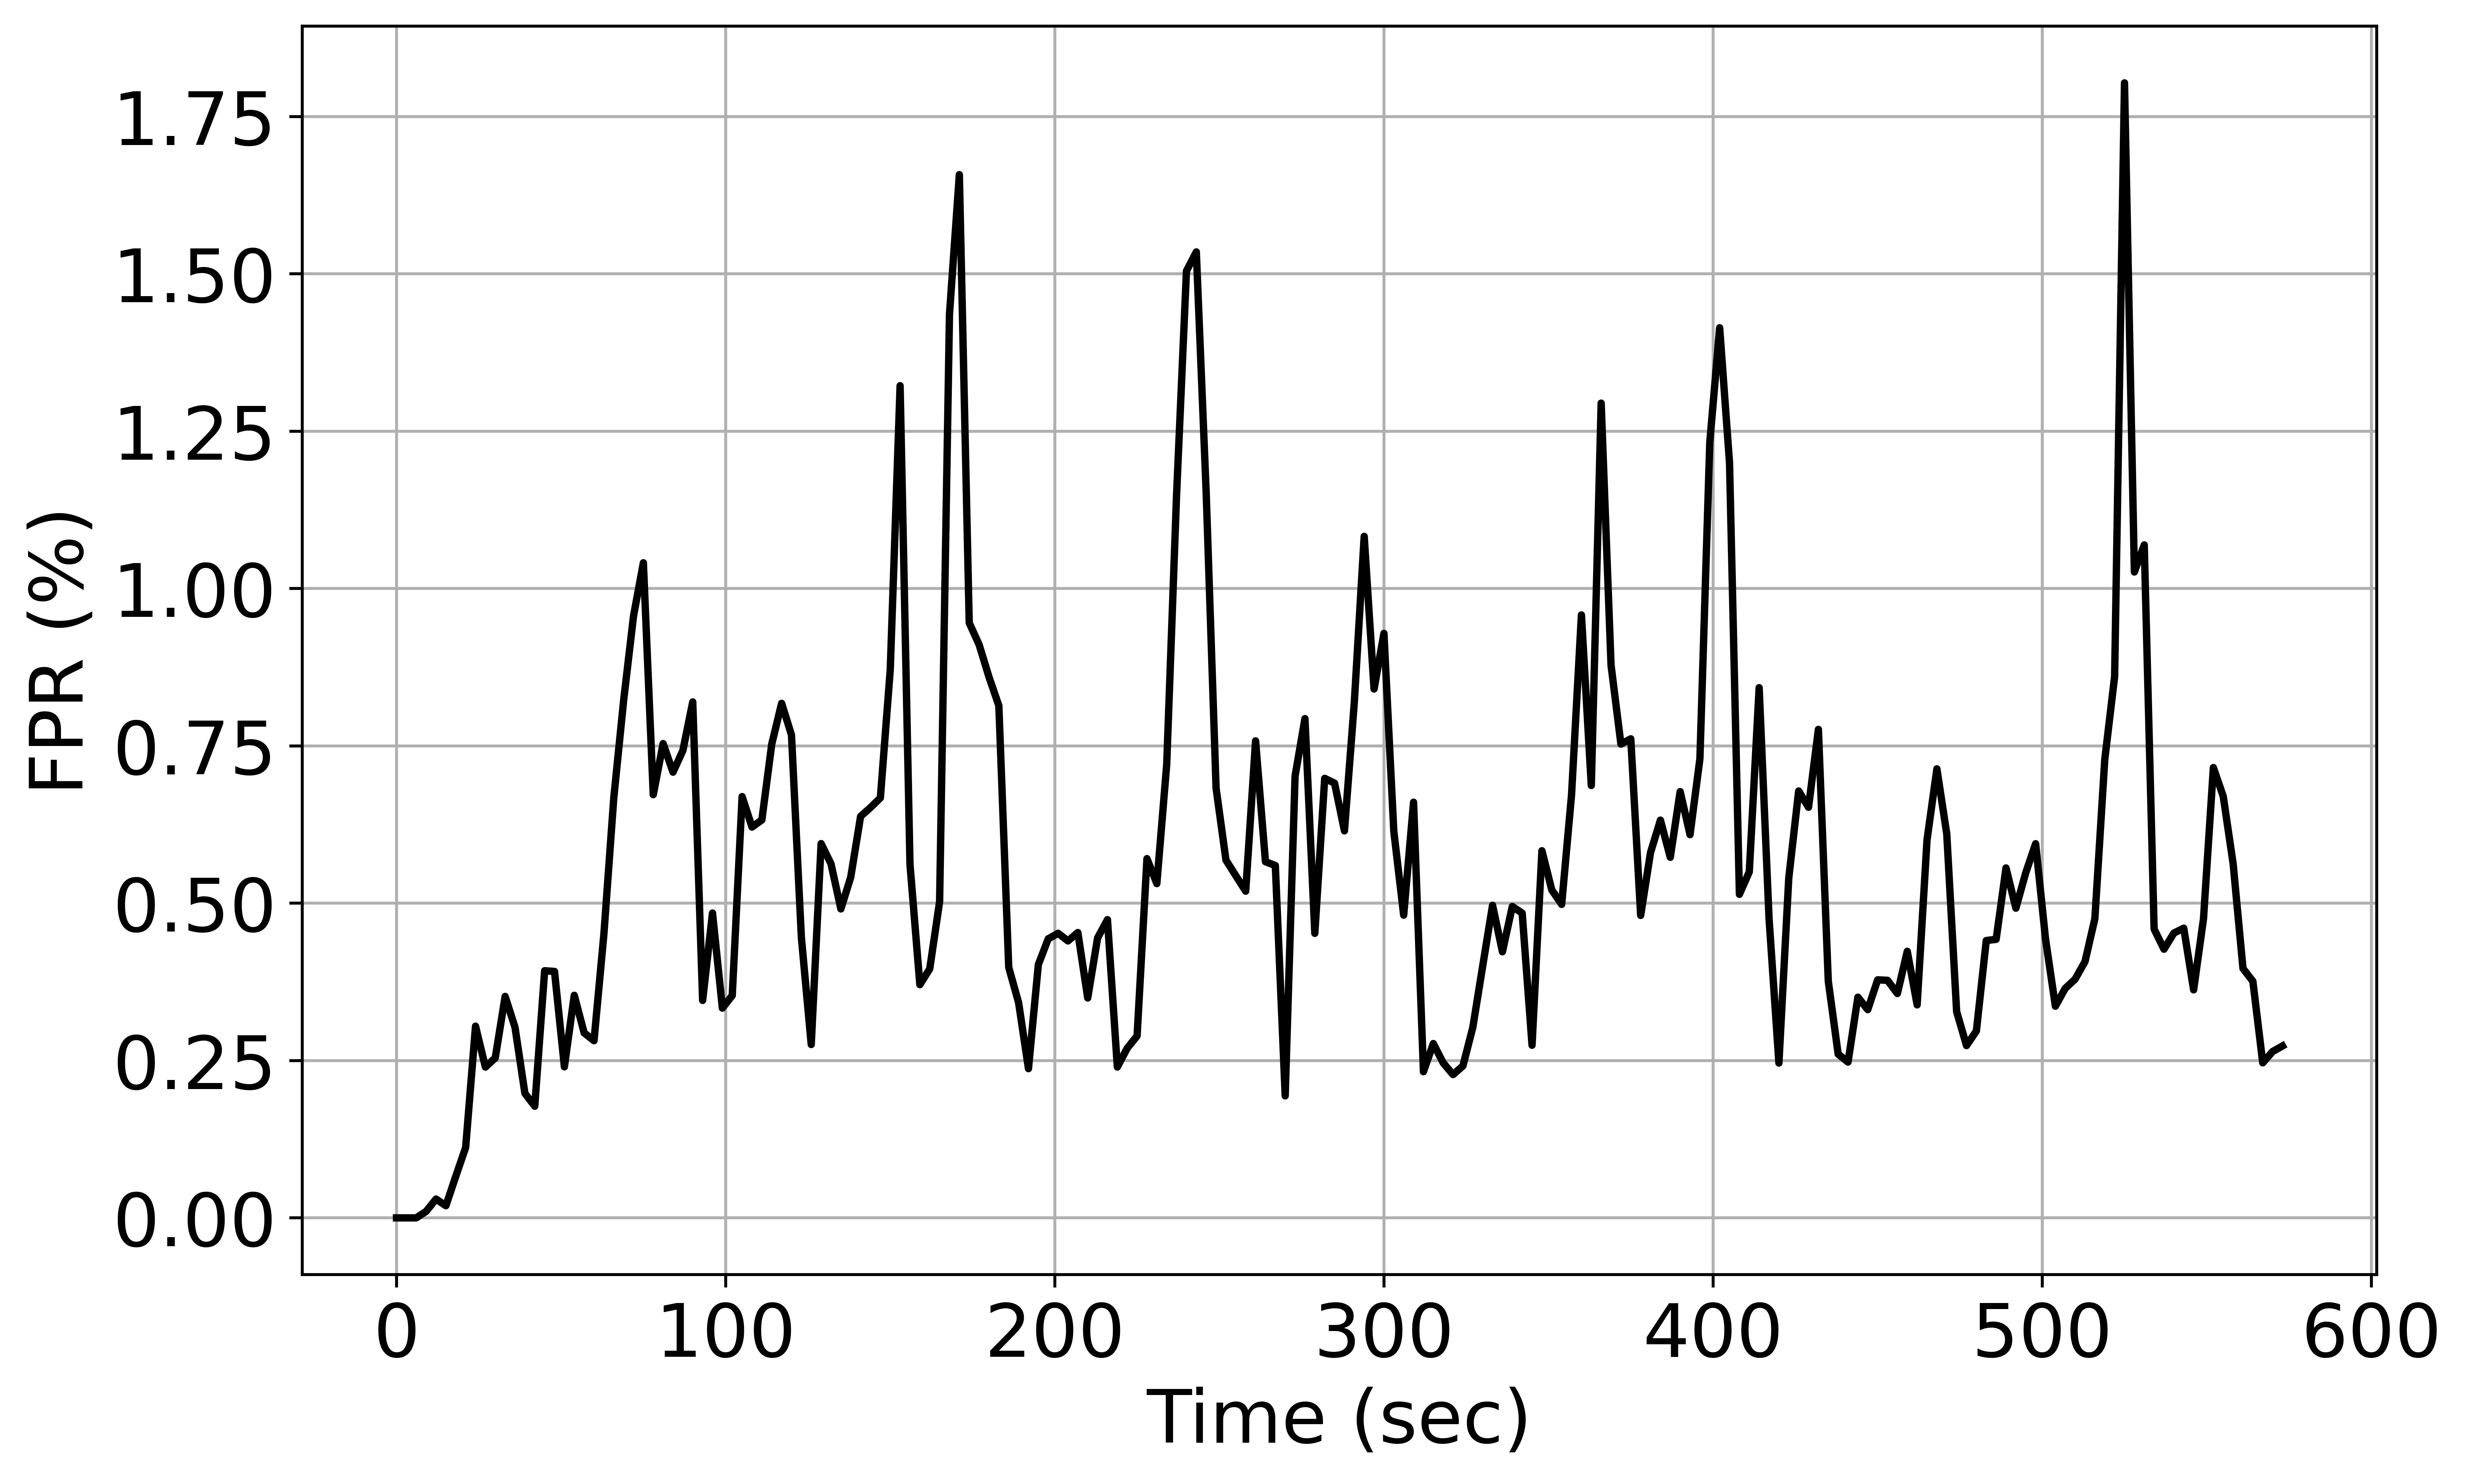

In [136]:
# Matplot Configs
matplotlib.rc('text', usetex=False)
print (matplotlib.rcParams['backend']) 
#matplotlib.use('Agg')

# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize']= [9.71, 6] # For heatmap
# matplotlib.rcParams['figure.figsize']= [3.125, 1.93]  # Golden ratio
# matplotlib.rcParams['figure.figsize']= [3.125, 1.56]  # Squash for more space
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family']= 'sans' #, 'sans serif', 'sans-serif'
# matplotlib.rcParams['font.sans-serif']='Times'
matplotlib.rcParams['font.size']= 20 # 8
matplotlib.rcParams['legend.fontsize']= 30
matplotlib.rcParams['legend.fancybox']= True
# matplotlib.rcParams['axes.linewidth']= 0.5
# matplotlib.rcParams['patch.linewidth']= 0.5
# matplotlib.rcParams['lines.linewidth']= 2
# matplotlib.rcParams['grid.linewidth']= 0.1
# matplotlib.rcParams['xtick.major.width']= 0.25
# matplotlib.rcParams['xtick.minor.width']= 0.25
# matplotlib.rcParams['ytick.major.width']= 0.25
# matplotlib.rcParams['ytick.minor.width']= 0.25
# matplotlib.rcParams['legend.numpoints']= 1

color_n=['k','c','b','r','m','y','g','tab:orange','tab:purple'] 
markers=['o','*','^','s','*','o','d','o','*','^','1','4']
linestyles=[ '-',':','--','-.','--',':','-','-.', '--',':']


plot_line(data_dict, order, "Time (sec)", "FPR (%)", "Count", legend=False, legend_loc="upper center",
             Xmax=None, Xmin=None, fname=None, isLog=False, figsize=None)


In [130]:
import pylab as pl

def plot_stacked_bars(data_dict, order, species, xlabel, ylabel, width=0.5, legend=False, legend_loc='upper right', 
               Ymax=None, Ymin=None, fname=None, isLog=False, figsize=None, legend_prefix=""):
    if figsize == None:
        fig = plt.figure(dpi=700)
    else:
        fig = plt.figure(figsize=figsize, dpi=700)

    # To determine to plotting order
    if order is None:
        labels = sorted(list(data_dict.keys()))
    else:
        labels = order
    print("Labels:", labels)

    fig, ax1 = plt.subplots()
    bottom = np.zeros(len(species))

    for i in range(len(labels)):
        label = labels[i]
        values= data_dict[label]
        p = ax1.bar(species, values, width, label=label, color=color_n[i], bottom=bottom)
        bottom += values

    if legend:
        ax1.legend(labels, loc=legend_loc, title_fontsize=16/1.5,
                   ncol=1, fancybox=False, shadow=False, fontsize=14, frameon=True,
                   facecolor="white") # framealpha=1., bbox_to_anchor=(0.98, 0.68),

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    if isLog:
        pl.yscale('log')
    if Ymin != None:
        ax1.set_ylim(bottom=Ymin)
    if Ymax != None:
        ax1.set_ylim(top=Ymax)

    # ax.set_ylim(top=0.2) 
    ax1.grid(True)
    ax1.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    if fname != None:
        plot_name= fname+'.eps'
        pl.savefig(plot_name)
        plot_name= fname+'.png'
        pl.savefig(plot_name, dpi=700)


Labels: ['Other', 'Find optimal config', 'Create configs']


<Figure size 6797x4200 with 0 Axes>

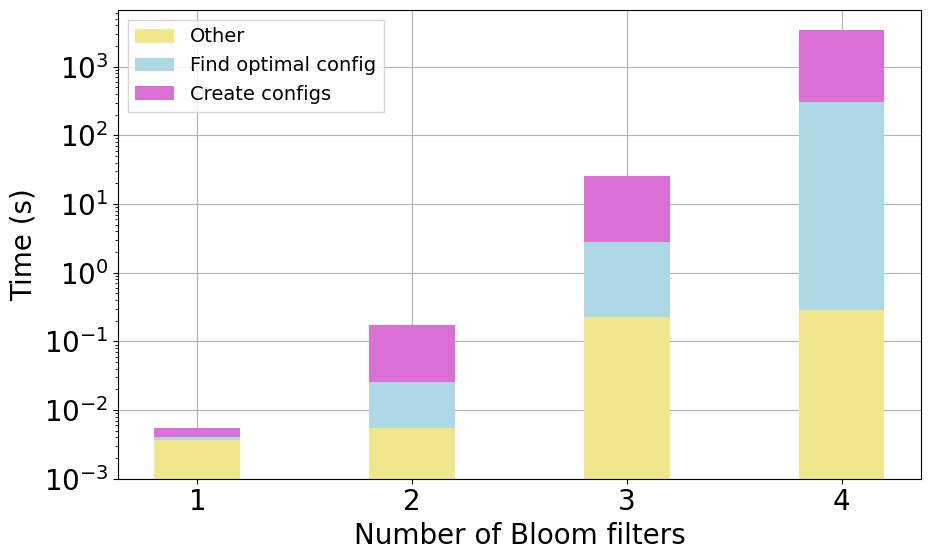

In [131]:
species = (
    "1",
    "2",
    "3",
    "4",
)
data_dict = {
    "Other": np.array([0.003639, 0.005425, 0.225522, 0.285921]),
    "Find optimal config": np.array([0.00036300, 0.02051300, 2.54253, 303.24342]),
    "Create configs": np.array([0.00152300, 0.14836000, 23.17004500, 3057.02067])
}
order = ["Other", "Find optimal config", "Create configs"]
color_n=["khaki", "lightblue", "orchid"]

plot_stacked_bars(data_dict, order, species, "Number of Bloom filters", "Time (s)", legend=True, width=0.4, legend_loc="upper left",
             Ymax=None, Ymin=0.001, fname=None, isLog=True, figsize=None)
